# Data Collection and Formatting

In [1]:
import pandas as pd
import tarfile
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

%run -i "functions/unzip.py"
%run -i "functions/scrape_platforms.py"
%run -i "functions/scrape_SotU.py"

# Text Data
### Political Platforms

In [ ]:
years = ['1972', '1976', '1980', '1984', '1988', '1992', '1996', 
         '2000', '2008', '2012', '2016']
platforms = scrape_platforms(years)
platforms.head()

### State of the Union Addresses

In [ ]:
speeches = scrape_SotU()

### Debates

In [ ]:
url = 'https://www.presidency.ucsb.edu/documents/presidential-debate-the-university-nevada-las-vegas'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
debate = soup.find_all('p')
for deb in debate:
    print(deb.text)

# Survey Data
### Convert Data to Dataframes
###### Weights
Based on the sample weights provided by the General Social Survey, it appears that some samples were significantly over and underrepresented. In order to account for this weights will be applied to this analysis. In order to maintain a reasonable size of the data rather than achieving the right proportions by using the complete weights, I will use the rounded values to the nearest tenth.  

In [2]:
weights = unzip('Weights')

In [3]:
weights.head()

,year,id,Weight variable
0,1972,0,0.4446
1,1972,1,0.8893
2,1972,2,0.8893
3,1972,3,0.8893
4,1972,4,0.8893


In [4]:
weights['Weight variable'].describe()

count    64814.000000
mean         1.000015
std          0.468172
min          0.391825
25%          0.550100
50%          0.970900
75%          1.098500
max          8.739876
Name: Weight variable, dtype: float64

In [5]:
def weight(df):
    return df.loc[df.index.repeat(round(weights['Weight variable']*10, 0))].reset_index()

###### Voter Identity

In [6]:
party = unzip('Voter_Identity')
party = party[['year', 'Political party affiliation']]
party = weight(party)
party.drop('index', axis = 1, inplace= True)

In [7]:
party.head()

,year,Political party affiliation
0,1972,"Ind,near dem"
1,1972,"Ind,near dem"
2,1972,"Ind,near dem"
3,1972,"Ind,near dem"
4,1972,Not str democrat


In [8]:
party.rename(columns = {'Political party affiliation':'party'}, inplace=True)

In [9]:
party['party'].value_counts()

Not str democrat      131833
Not str republican    101264
Independent           100052
Strong democrat        99652
Ind,near dem           76687
Strong republican      63506
Ind,near rep           58747
Other party            10708
No answer               4099
Don't know               143
Name: party, dtype: int64

In [10]:
party.loc[party['party']=='Not str democrat', 'party']= 'Democrat'
party.loc[party['party']=='Not str republican', 'party']= 'Republican'
party.loc[party['party']=='Strong democrat', 'party']= 'Strong Democrat'
party.loc[party['party']=='Ind,near dem', 'party']= 'Lean Democrat'
party.loc[party['party']=='Strong republican', 'party']= 'Strong Republican'
party.loc[party['party']=='Ind,near rep', 'party']= 'Lean Republican'
party.loc[party['party']=='Other party', 'party']= 'Other'

In [11]:
party_dum = pd.get_dummies(party, prefix= '', prefix_sep= '')

In [12]:
grouped = party_dum.groupby('year').sum().reset_index()

In [13]:
grouped.head()

,year,Democrat,Don't know,Independent,Lean Democrat,Lean Republican,No answer,Other,Republican,Strong Democrat,Strong Republican
0,1972,4304.0,0.0,1623.0,1708.0,973.0,48.0,693.0,2250.0,3322.0,1151.0
1,1973,3787.0,0.0,1442.0,1888.0,1397.0,132.0,669.0,2206.0,2264.0,1236.0
2,1974,3708.0,130.0,1454.0,1992.0,1058.0,123.0,596.0,2114.0,2440.0,1013.0
3,1975,3494.0,0.0,1993.0,2049.0,1240.0,50.0,123.0,2339.0,2527.0,909.0
4,1976,4136.0,0.0,2494.0,2178.0,1081.0,35.0,30.0,2288.0,2224.0,885.0


In [14]:
parties = ['Democrat', 'Independent', 'Lean Democrat', 
           'Lean Republican', 'Other', 'Republican', 
           'Strong Democrat', 'Strong Republican']
grouped['total'] = 0
for party in parties:
    grouped['total'] += grouped[party]
grouped['total'].head() 
for party in parties:
    grouped['percent '+ party]= grouped[party]/grouped['total']

In [15]:
grouped.columns

Index(['year', 'Democrat', 'Don't know', 'Independent', 'Lean Democrat',
       'Lean Republican', 'No answer', 'Other', 'Republican',
       'Strong Democrat', 'Strong Republican', 'total', 'percent Democrat',
       'percent Independent', 'percent Lean Democrat',
       'percent Lean Republican', 'percent Other', 'percent Republican',
       'percent Strong Democrat', 'percent Strong Republican'],
      dtype='object')

No handles with labels found to put in legend.


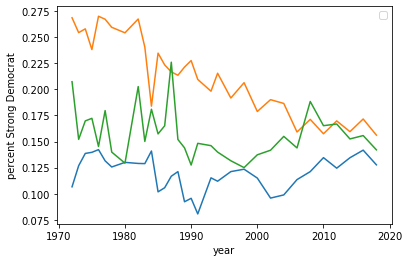

In [28]:
sns.lineplot(x= 'year', y = 'percent Lean Democrat', data= grouped)
sns.lineplot(x= 'year', y = 'percent Democrat', data= grouped)
sns.lineplot(x= 'year', y = 'percent Strong Democrat', data= grouped)
plt.legend();

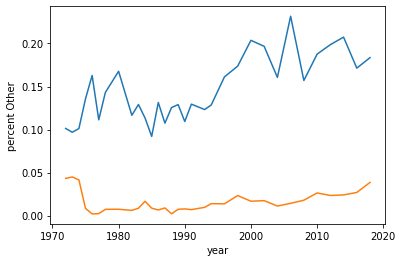

In [20]:
sns.lineplot(x= 'year', y = 'percent Independent', data= grouped)
sns.lineplot(x= 'year', y = 'percent Other', data= grouped);

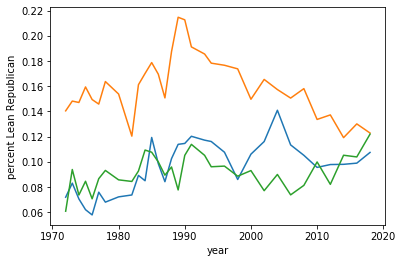

In [24]:
sns.lineplot(x= 'year', y = 'percent Strong Republican', data= grouped)
sns.lineplot(x= 'year', y = 'percent Republican', data= grouped)
sns.lineplot(x= 'year', y = 'percent Lean Republican', data= grouped);

###### Abortion Opinions
To reduce dimensionality in the data, I will combine the reasons for abortion into three categories: health, economics, and right-to-choose. There will also be a category for abolishing legal abortion. 

In [ ]:
abortion = unzip('Abortion')
abortion.info()

In [ ]:
abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')|
             (abortion['Married--wants no more children'] == 'Yes')|
             (abortion["Woman's health seriously endangered"] == 'Yes')|
             (abortion["Low income--cant afford more children"] == 'Yes')|
             (abortion["Pregnant as result of rape"] == 'Yes')|
             (abortion['Not married']=='Yes'), 'abortion'] = 'conditional'

abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')&
             (abortion['Married--wants no more children'] == 'Yes')&
             (abortion["Woman's health seriously endangered"] == 'Yes')&
             (abortion["Low income--cant afford more children"] == 'Yes')&
             (abortion["Pregnant as result of rape"] == 'Yes')&
             (abortion['Not married']=='Yes'), 'abortion'] = 'unrestricted'

abortion.loc[abortion['Abortion if woman wants for any reason']== 'Yes', 'abortion']= 'unrestricted'
abortion['abortion'].fillna('never', inplace = True)
abortion.head()

In [ ]:
abortion = abortion[['id', 'abortion']]

In [ ]:
abortion = weight(abortion)

In [ ]:
data = abortion.join(party, how= 'left')

In [ ]:
data = pd.get_dummies(data)

In [ ]:
data.head()

###### Family/ SES Background

In [ ]:
background = unzip('Background')

In [ ]:
background.columns

In [ ]:
for col in background.columns:
    print(background[col].value_counts())
    print('\n')

In [ ]:
background.rename(columns = {"Father's occupational prestige score using threshold method (2010)": 'father_prestige',
                             "Mother's occupational prestige score using threshold method (2010)": 'mother_prestige',
                             'Religion in which raised': 'raised_relig', 
                             'How many grandparents born outside u.s.': 'immigrant_gpar', 
                             'Were rs parents born in this country': 'immigrant_par', 
                             'Was r born in this country': 'immigrant'}, inplace=True)

I will encode the immigration status of parents so that the number of grandparents and parents born outside of the country are counted. Parents born in the U.S will be coded as 0s. Because this data will likely not be used for modeling, I will keep not applicable values as they are. 

In [ ]:
background.loc[(background['raised_relig']=='Not applicable')|
               (background['raised_relig']=='No answer')|
               (background['raised_relig']=="Don't know"), 'raised_relig']= 'Other'
background.loc[(background['immigrant_gpar']== 'All in u.s'), 'immigrant_gpar']= 0
background.loc[(background['immigrant_par']=='Both in u.s')|
               (background['immigrant_par']=='Mother; fa. dk')|
               (background['immigrant_par']=='Father; mo.dk'), 'immigrant_par']= 0
background.loc[(background['immigrant_par']=='Neither in u.s')|
               (background['immigrant_par']=='Not mother;fa.dk')|
               (background['immigrant_par']=='Not father;mo.dk'), 'immigrant_par']= 2
background.loc[(background['immigrant_par']=='Mother only')|
               (background['immigrant_par']=='Father only'), 'immigrant_par']= 1
background.loc[(background['immigrant']=='Yes'), 'immigrant']= 'no'
background.loc[(background['immigrant']=='No'), 'immigrant']= 'yes'
background.loc[(background['immigrant']=='Not applicable')|
               (background['immigrant']=='No answer')|
               (background['immigrant']=="Don't know"), 'immigrant']= 'n/a'

The 'Rs living standard compared to parents' is messy and highly incomplete, so I will drop it for this analysis. In addition, after consideration, parental education levels are more appropriately placed in the education table so they will also be dropped from this table.  

In [ ]:
background.drop(['Rs living standard compared to parents', 
                 'Fathers highest degree', 'Mothers highest degree'], axis= 1, inplace= True)

In [ ]:
background = weight(background)

In [ ]:
background.to_csv('data/cleaned_and_weighted/background.csv')

##### Criminal Justice Attitudes

In [ ]:
crim_justice = unzip('Criminal_Justice')
crim_justice.columns

In [ ]:
crim_justice[crim_justice['Ever approve of police striking citizen']=='Yes']['Citizen attacking policeman with fists'].value_counts()

The police striking citizens columns lack information on how the police response is defined, and will likely be difficult to interpret given the nature of this analysis. Unfortunately I will have to drop them. 

In [ ]:
crim_justice.drop(['Citizen attacking policeman with fists', 
                   'Citizen attempting to escape custody', 
                   'Citizen questioned as murder suspect', 
                   'Citizen said vulgar or obscene things', 
                   'Ever approve of police striking citizen'], axis = 1, inplace = True)

In [ ]:
crim_justice.rename(columns = {'Should marijuana be made legal': 'legalize_marijuana',
                             'Courts dealing with criminals': 'sentencing',
                             'Favor or oppose death penalty for murder': 'death_penalty', 
                             'Afraid to walk at night in neighborhood': 'fear'}, inplace=True)

In [ ]:
crim_justice = weight(crim_justice)

In [ ]:
crim_justice.to_csv('data/cleaned_and_weighted/crim_justice.csv')

##### Education

In [ ]:
education = unzip('Education')
education.columns

In [ ]:
for col in education.columns:
    print(education[col].value_counts())
    print('\n')

With so many not applicable entries for the field of degree, it is more appropriate to remove them from the analysis. 

In [ ]:
education.drop(['The field of degree r earned'], axis=1, inplace=True)

In [ ]:
education.rename(columns = {'Highest year of school completed':'school_years',
                            'Highest year school completed, father':'school_years_dad', 
                            'Highest year school completed, mother':'school_years_mom',
                            'Rs highest degree':'degree',
                            'Fathers highest degree':'degree_dad',
                            'Mothers highest degree': 'degree_mom'}, inplace=True)

Encode nan information as a placeholder so that it can be easily removed later in the analysis. 

In [ ]:
education.loc[(education['school_years']=='No answer')|
              (education['school_years']=='Not applicable')|
              (education['school_years']== "Don't know"), 'school_years']= -9
education.loc[(education['school_years_dad']=='No answer')|
              (education['school_years_dad']=='Not applicable')|
              (education['school_years_dad']== "Don't know"), 'school_years_dad']= -9
education.loc[(education['school_years_mom']=='No answer')|
              (education['school_years_mom']=='Not applicable')|
              (education['school_years_mom']== "Don't know"), 'school_years_mom']= -9

In [ ]:
education.head()

In [ ]:
education = pd.get_dummies(data= education, columns=['degree', 'degree_dad', 'degree_mom'])

In [ ]:
education = weight(education)

In [ ]:
education.to_csv('data/cleaned_and_weighted/education.csv')

##### Employment

In [ ]:
employment = unzip('Employment')
employment.columns

In [ ]:
for col in employment.columns:
    print(employment[col].value_counts())
    print('\n')

In [ ]:
employment.drop(['Is r likely to lose job', 'Could r find equally good job', 
                 'Job or housework', 'If rich, continue or stop working', 
                 'Workers need strong unions'], axis=1, inplace = True)

In [ ]:
employment.rename(columns= {'Does r or spouse belong to union': 'union',
                            'Number of hours usually work a week': 'wrk_hrs',
                            'Labor force status': 'job_status',
                            'Rs occupational prestige score using threshold method (2010)': 'prestige'}, 
                  inplace = True)

In [ ]:
employment.loc[(employment['union']=='Neither belongs', 'union')]= 'non-member'
employment.loc[(employment['union']=='R belongs')|
               (employment['union']=='Spouse belongs')|
               (employment['union']=='R and spouse belong'), 'union']= 'member'

In [ ]:
employment.head()

In [ ]:
employment = weight(employment)

In [ ]:
employment.to_csv('data/cleaned_and_weighted/employment.csv')

###### Family Values

In [ ]:
fam_vals = unzip('Family_Values')
fam_vals.columns

In [ ]:
for col in fam_vals.columns:
    print(fam_vals[col].value_counts())
    print('\n')

In [ ]:
fam_vals.rename(columns= {'Better for man to work, woman tend home': 'trad_roles', 
                          'Preschool kids suffer if mother works': 'mom_wrk_kids_suffer', 
                          'Ideal number of children': 'bst_num_chld', 
                          'To help others': 'tch_to_help',
                          'To work hard': 'tch_to_wrk', 
                          'To think for ones self': 'tch_ind', 
                          'To be well liked or popular': 'tch_pop',
                          'To obey': 'tch_obey', 
                          'Number of children': 'num_chld',
                          'Number of family generations in household': 'num_gen'}, inplace=True)

In [ ]:
fam_vals.drop(['Rs kids living standard compared to r', 'Rs living standard compared to parents', 
               'Highest year school completed, mother', 'Highest year school completed, father', 
               'Number of brothers and sisters', 'Favor spanking to discipline child'], axis=1, inplace=True)

In [ ]:
fam_vals.loc[fam_vals['num_gen']=='1 gen', 'num_gen']= 1
fam_vals.loc[(fam_vals['num_gen']=='2 gens, children')|
             (fam_vals['num_gen']=='2 gens, parents')|
             (fam_vals['num_gen']=='2 gens, grandchldrn'), 'num_gen']= 2
fam_vals.loc[(fam_vals['num_gen']=='3 gens, grandchldrn')|
             (fam_vals['num_gen']=='3 gens, chld, par'), 'num_gen']= 3
fam_vals.loc[fam_vals['num_gen']=='4 gens', 'num_gen']= 4

In [ ]:
fam_vals.head()

In [ ]:
fam_vals = weight(fam_vals)

In [ ]:
fam_vals.to_csv('data/cleaned_and_weighted/fam_vals.csv')

###### Gender and Sexuality

In [ ]:
gender = unzip('Gender_and_Sexuality')
gender.columns

In [ ]:
for col in gender.columns:
    print(gender[col].value_counts())
    print('\n')

In [ ]:
gender.drop(['Should hire and promote women                            ', 
             'For or against preferential hiring of women      ', 
             'Better for man to work, woman tend home', 'Preschool kids suffer if mother works',
             'Sex before marriage -- teens 14-16', 'Birth control to teenagers 14-16'], 
            axis = 1, inplace = True)

In [ ]:
gender.rename(columns ={'Sex before marriage':'sex_before_marr',
                        'Divorce laws': 'divorce', 
                        'Sex education in public schools':'sex_ed',
                        'Women not suited for politics': 'no_women_pol',
                        'Homosexuals should have the right to marry':'gay_marr'})

In [ ]:
gender = weight(gender)
gender.to_csv('data/cleaned_and_weighted/gender.csv')

###### Identity

In [ ]:
pers_id = unzip('Identity')
pers_id.columns

In [ ]:
for col in pers_id.columns:
    print(pers_id[col].value_counts())
    print('\n')

In [ ]:
pers_id.rename(columns={'Age of respondent':'age', 
                      'Respondents sex':'sex', 
                      'Race of respondent':'race',
                      'Region of interview':'region'}, inplace = True)

In [ ]:
pers_id = weight(pers_id)

In [ ]:
pers_id.to_csv('data/cleaned_and_weighted/pers_id.csv')

###### Lifestyle

In [ ]:
lifestyle = unzip('Lifestyle')
lifestyle.columns

In [ ]:
for col in lifestyle.columns:
    print(lifestyle[col].value_counts())
    print('\n')

In [ ]:
lifestyle.rename(columns = {'Hours per day watching tv':'hrs_tv',
                            'How often does r read newspaper':'paper',
                            'Have gun in home':'gun',
                            'Is life exciting or dull':'life',
                            'General happiness':'happy',
                            "R's age when 1st child born":'age_at_frst_chld',
                            'Marital status':'married',
                            'Does r own or rent home?':'rent_or_own'}, inplace = True)

In [ ]:
lifestyle.drop(['Does r or spouse hunt', 'Spend evening at bar', 
                'Spend evening with friends', 'Spend evening with neighbor', 
                'Spend evening with relatives', 'Age of respondent', 'Number of children',
                'Number of hours usually work a week'], axis=1, inplace=True)

In [ ]:
lifestyle = weight(lifestyle)
lifestyle.to_csv('data/cleaned_and_weighted/lifestyle.csv')

###### Opinions

In [ ]:
opinions = unzip('Opinions')
opinions.columns

In [ ]:
for col in opinions.columns:
    print(opinions[col].value_counts())
    print('\n')

In [ ]:
opinions = weight(opinions)

In [ ]:
opinions.to_csv('data/cleaned_and_weighted/opinions.csv')

###### Race Relations

In [ ]:
race = unzip('Race_Relations')
race.columns

In [ ]:
for col in race.columns:
    print(race[col].value_counts())
    print('\n')

Because of the ways in which these variables were coded, many of them are either redundant with other questions, or difficult to gain meaningful information from.  

In [ ]:
race.drop(['Hard working - lazy', 'Hard working - lazy.1', 
           'Rich - poor', 'Rich - poor.1', 'Blacks overcome prejudice without favors ',
           'Any opp. race in neighborhood', 'Favor law against racial intermarriage', 
           'Improving the conditions of blacks'], axis = 1, inplace = True)

In [ ]:
race.loc[race['Should govt aid blacks?']=='Agree with both', 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=='No special treatment', 'Should govt aid blacks?']= 'strongly oppose'
race.loc[race['Should govt aid blacks?']== 4, 'Should govt aid blacks?']= 'oppose'
race.loc[race['Should govt aid blacks?']=='Govt help blks', 'Should govt aid blacks?']= 'strongly favor'
race.loc[race['Should govt aid blacks?']== 2, 'Should govt aid blacks?']= 'favor'
race.loc[race['Should govt aid blacks?']=="Don't know", 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=="No answer", 'Should govt aid blacks?']= 'no opinion'

In [ ]:
race = weight(race)

In [ ]:
race.to_csv('data/cleaned_and_weighted/race.csv')

###### Religion

In [ ]:
religion = unzip('Religion')
religion.columns

In [ ]:
for col in religion.columns:
    print(religion[col].value_counts())
    print('\n')

In [ ]:
religion.drop(['Bible prayer in public schools'], axis = 1, inplace = True)

In [ ]:
religion = weight(religion)

In [ ]:
religion.to_csv('data/cleaned_and_weighted/religion.csv')

###### Socioeconomic Status

In [ ]:
ses = unzip('SES')
ses.columns

In [ ]:
for col in ses.columns:
    print(ses[col].value_counts())
    print('\n')

In [ ]:
ses.drop(['Rs income in constant $', 'Standard of living of r will improve', 
          'Rs kids living standard compared to r', 'Rs living standard compared to parents', 
          'Change in financial situation', 'Rs occupational prestige score using threshold method (2010)'], 
         axis = 1, inplace = True)

In [ ]:
ses = weight(ses)

In [ ]:
ses.to_csv('data/cleaned_and_weighted/ses.csv')

###### Systems

In [ ]:
systems = unzip('Systems')
systems.columns

In [ ]:
for col in systems.columns:
    print(systems[col].value_counts())
    print('\n')

In [ ]:
systems.drop(['Confidence in medicine'], axis = 1, inplace = True)

In [ ]:
systems = weight(systems)
systems.to_csv('data/cleaned_and_weighted/systems.csv')